### Setup

If you want to write your own code and not follow this format, it is ok. Just make sure to use the same hyperparameters and models. If you see convergence sooner during the training, you may use fewer iterations.

In [1]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F

# Latent dimensions
z = 10
# Training iterations
iter_max = 200
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [2]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    # i committed some changes.
    
    # Create pre-processed training and test sets
    #X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    #y_train = train_loader.dataset.train_labels.to(device)
    #X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    #y_test = test_loader.dataset.test_labels.to(device)

    #return train_loader, (X_test, y_test)
    return train_loader, test_loader

# i committed some changes.
#train_loader, _ = get_mnist_data(device, batch_size)
train_loader, test_loader = get_mnist_data(device, batch_size)

train_loader

### Utility Functions
- Complete the code for the function ```sample_gaussian```

In [3]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    ################################################################################
    # TODO: complete the code here
    # Task: Sample z

    # ensure that m and v have the same shape:
    assert m.size() == v.size(), "Mean and variance must have the same shape."

    # we sample from a standard normal distribution, in the same shape as "m":
    epsilon = torch.randn_like(m)

    # and now we compute z, in other words, we sample using reparameterization trick: 
    z = m + torch.sqrt(v) * epsilon

    # End 
    ################################################################################
    
    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

def duplicate(x, rep):
    """
    Duplicates x along dim=0

    Args:
        x: tensor: (batch, ...): Arbitrary tensor
        rep: int: (): Number of replicates. Setting rep=1 returns orignal x

    Returns:
        _: tensor: (batch * rep, ...): Arbitrary replicated tensor
    """
    return x.expand(rep, *x.shape).reshape(-1, *x.shape[1:])

def log_normal(x, m, v):
    """
    Computes the elem-wise log probability of a Gaussian and then sum over the
    last dim. Basically we're assuming all dims are batch dims except for the
    last dim.

    Args:
        x: tensor: (batch_1, batch_2, ..., batch_k, dim): Observation
        m: tensor: (batch_1, batch_2, ..., batch_k, dim): Mean
        v: tensor: (batch_1, batch_2, ..., batch_k, dim): Variance

    Return:
        log_prob: tensor: (batch_1, batch_2, ..., batch_k): log probability of
            each sample. Note that the summation dimension is not kept
    """
    log_std = torch.log(torch.sqrt(v))
    log_probs = -((x - m) ** 2) / (2 * v) - log_std - np.log(np.sqrt(2 * np.pi))
    log_prob = log_probs.sum(-1)

    ################################################################################
    # End of code modification
    ################################################################################
    return log_prob

def log_mean_exp(x, dim):
    """
    Compute the log(mean(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which mean is computed

    Return:
        _: tensor: (...): log(mean(exp(x), dim))
    """
    return log_sum_exp(x, dim) - np.log(x.size(dim))

def log_sum_exp(x, dim=0):
    """
    Compute the log(sum(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which sum is computed

    Return:
        _: tensor: (...): log(sum(exp(x), dim))
    """
    max_x = torch.max(x, dim)[0]
    new_x = x - max_x.unsqueeze(dim).expand_as(x)
    return max_x + (new_x.exp().sum(dim)).log()

### Base Models

In [4]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


### VAE Model

- Complete the functions ```negative_elbo_bound``` and ```negative_iwae_bound```. Make sure to use functions provided in the ***Utility*** and ***Base Model*** sections for your benefit when completing the code.

In [5]:
class VAE(nn.Module):
    def __init__(self, name='vae', z_dim=2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim

        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)

    def negative_elbo_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: complete the code here
        # Task: Compute negative Evidence Lower Bound and its KL and Reconstruction term
        # Note that nelbo = kl + rec
        # Outputs should all be scalar

        # this piece of code is mostly inspired by:
        # https://colab.research.google.com/drive/1_yGmk8ahWhDs23U4mpplBFa-39fsEJoT?usp=sharing
        # https://github.com/JohanYe/IWAE-pytorch/blob/059527de3da8920b0b7688dea516ce2adf76202b/model/PytorchIWAE.py#L72
        # https://github.com/ermongroup/sliced_score_matching/blob/master/losses/vae.py

        # for understanding elbo, I checked this too:
        # https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed
        # https://yugeten.github.io/posts/2020/06/elbo/

        # overall, i tried to adapt what i learnt and understood from this metric with the utility functions i'm supposed to use.
        

        # encode the input, x, and get mean and variance:
        m_enc, v_enc = self.enc.encode(x)

        # based on those values, sample z from gaussian distribution using reparameterization trick:
        z = sample_gaussian(m_enc, v_enc)

        
        # reconstruction error section of the loss:

        # get probability distribution of logits from giving z to the decoder:
        x_hat = self.dec.decode(z)

        # calculate the log. of probabilities between our input and the reconstructed input,
        # or should I say, the average reconstruction error:
        rec_values = log_bernoulli_with_logits(x, x_hat)
        rec = -torch.mean(rec_values)
        
        
        # kl section of the loss:

        # creating a similar (shape-wise) tensors for the priors, p_m and p_v:
        # (i mounted them onto cuda, since i was receiving errors if i didn't do it)
        m_prior = torch.zeros(m_enc.shape).to(device)
        v_prior = torch.ones(v_enc.shape).to(device)
        
        # calculate Kl values and then, take an average from them:
        kl_values = kl_normal(m_enc, v_enc, m_prior, v_prior)
        kl = torch.mean(kl_values)

        
        # compute the negative elbo:
        nelbo = rec + kl

        # End 
        ################################################################################
        
        return nelbo, kl, rec
    
    def negative_iwae_bound(self, x, iw):
        """
        Computes the Importance Weighted Autoencoder Bound
        Additionally, we also compute the ELBO KL and reconstruction terms

        Args:
            x: tensor: (batch, dim): Observations
            iw: int: (): Number of importance weighted samples

        Returns:
            niwae: tensor: (): Negative IWAE bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: Modify/complete the code here
        # Compute niwae (negative IWAE) with iw importance samples, and the KL
        # and Rec decomposition of the Evidence Lower Bound
        #
        # Outputs should all be scalar
        ################################################################################

        # to understand how this metric actually works, i studied some sources alongside the paper:
        # https://bochang.me/blog/posts/iwae/
        # https://justin-tan.github.io/blog/2020/06/20/Intuitive-Importance-Weighted-ELBO-Bounds
        # https://borea17.github.io/paper_summaries/iwae/
        # https://github.com/JohanYe/CS294-158/tree/master/Hw3/Ex1

        # overall, i tried to adapt what i learnt and understood from this metric with the utility functions i'm supposed to use.
        

        # encode the input, x, and get mean and variance:
        m_enc, v_enc = self.enc.encode(x)

        # we need to make a copy of the tensor values and add "iw" to it along the 0-axis for each:
        iw_m_enc = duplicate(m_enc, iw)
        iw_v_enc = duplicate(v_enc, iw)

        # based on those values, sample z from gaussian distribution using reparameterization trick:
        z = sample_gaussian(iw_m_enc, iw_v_enc)
        

        # # reconstruction error section of the loss (same as before, no need for extra commenting):

        # again, we need to make a copy of the tensor values and add iw to it along the 0-axis:
        iw_x = duplicate(x, iw)

        # get probability distribution of logits from giving z to the decoder:
        x_hat = self.dec.decode(z)

        # calculate the log. of probabilities between our input and the reconstructed input,
        # or should I say, the average reconstruction error:
        rec_values = log_bernoulli_with_logits(iw_x, x_hat)
        rec = -torch.mean(rec_values)
        

        # niwae:
        # inspired by https://www.youtube.com/watch?app=desktop&v=U0T_jwVJcYI&ab_channel=ADASEGroup
        # and also # https://borea17.github.io/paper_summaries/iwae/

        iw_m_prior = torch.zeros(iw_m_enc.shape).to(device)
        iw_v_prior = torch.ones(iw_v_enc.shape).to(device)
        
        # computing log probability for both prior and posterior "iw"s
        log_prior = log_normal(z, iw_m_prior, iw_v_prior)
        log_posterior = log_normal(z, iw_m_enc, iw_v_enc)

        # we finally compute normalized log ratios and reshape to the shape of importance weights values:
        log_likelihood = log_prior + rec_values - log_posterior
        log_likelihood = log_likelihood.reshape(iw, x.shape[0])

        # compute niwae values for each instance, and then take average from them:
        niwae_values = log_mean_exp(log_likelihood, 0)
        niwae = -torch.mean(niwae_values)
        

        # kl section of the loss (same as before, no need for extra commenting):

        m_prior = torch.zeros(m_enc.shape).to(device)
        v_prior = torch.ones(v_enc.shape).to(device)
        
        kl_values = kl_normal(m_enc, v_enc, m_prior, v_prior)
        kl = torch.mean(kl_values)

        ################################################################################
        # End of code modification
        ################################################################################
        return niwae, kl, rec

    
    def loss(self, x):
        nelbo, kl, rec = self.negative_elbo_bound(x)
        loss = nelbo

        summaries = dict((
            ('train/loss', nelbo),
            ('gen/elbo', -nelbo),
            ('gen/kl_z', kl),
            ('gen/rec', rec),
        ))

        return loss, summaries

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


### Run model

- You will probably need to add some lines to this code. (Add test set, save statistics and plot, ...)

Note that Negative ELBO on the test set should be around 100. 

In [6]:

vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

m = [5, 50, 150]

nelbo_train = []
nelbo_test = []
niwae5_test = []
niwae50_test = []
niwae150_test = []

for i in tqdm(range(iter_max)):
    for batch_idx, (xu, yu) in enumerate(train_loader):
        
        optimizer.zero_grad()

        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        loss, summaries = vae.loss(xu)

        loss.backward()
        optimizer.step()
        
    #print(summaries['train/loss'])
    
    ################################################################################
    # TODO: complete the code here
    # report the loss terms across time for train and validation datasets
    #
    # You can choose to only perform validation once in every 10 (Or any other number 
    # depending on the speed of the algorithm on your machine) iterations and display  
    # the training and validation statistics on those iterataions.

    if i % 10 == 0:
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(test_loader):
                x = torch.bernoulli(x.to(device).reshape(x.size(0), -1))
                y = y.new(np.eye(10)[y]).to(device).float()
        
                _, summaries_test = vae.loss(x)

                iw_results_test = {iw: {"niwae": 0, "kl": 0, "rec_error": 0} for iw in m}
                iterations = 50
                
                for iw in m:
                    i = 0
                    for _ in range(iterations):
                        niwae, kl, rec_error = vae.negative_iwae_bound(x, iw)
                        
                        i += 1
                        
                        iw_results_test[iw]["niwae"] += niwae
                        iw_results_test[iw]["kl"] += kl
                        iw_results_test[iw]["rec_error"] += rec_error
                        
                    iw_results_test[iw]["niwae"] /= i
                    iw_results_test[iw]["kl"] /= i
                    iw_results_test[iw]["rec_error"] /= i
            
        print(f"\nTraining Performance (results from negative_elbo_bound method):")
        print(f"train/loss: {summaries['train/loss'].item()}, gen/elbo: {-summaries['gen/elbo'].item()}, gen/kl_z: {summaries['gen/kl_z'].item()}, gen/rec: {summaries['gen/rec'].item()}")

        print(f"\nTest Performance (results from negative_elbo_bound method):")
        print(f"test/loss: {summaries_test['train/loss'].item()}, gen/elbo: {-summaries_test['gen/elbo'].item()}, gen/kl_z: {summaries_test['gen/kl_z'].item()}, gen/rec: {summaries_test['gen/rec'].item()}")

        print(f"\nTest Performance (results from negative_iwae_bound method):")
        iws = list(iw_results_test.keys())
        niwaes = [-iw_results_test[iw]["niwae"] for iw in iws]
        print(f"{iws[0]}-niwae: {-niwaes[0]}, {iws[1]}-niwae: {-niwaes[1]}, {iws[2]}-niwae: {-niwaes[2]}")

        nelbo_train.append(-summaries['gen/elbo'].item())
        nelbo_test.append(-summaries_test['gen/elbo'].item())
        niwae5_test.append(-niwaes[0].item())
        niwae50_test.append(-niwaes[1].item())
        niwae150_test.append(-niwaes[2].item())
        
    # End
    ################################################################################

  0%|▍                                                                             | 1/200 [01:17<4:17:08, 77.53s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 123.56217956542969, gen/elbo: 123.56217956542969, gen/kl_z: 14.637104034423828, gen/rec: 108.92507934570312

Test Performance (results from negative_elbo_bound method):
test/loss: 126.65199279785156, gen/elbo: 126.65199279785156, gen/kl_z: 14.750197410583496, gen/rec: 111.90179443359375

Test Performance (results from negative_iwae_bound method):
5-niwae: 124.77561950683594, 50-niwae: 123.63327026367188, 150-niwae: 123.3686294555664


  6%|████▏                                                                        | 11/200 [03:34<1:31:46, 29.14s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 103.9534683227539, gen/elbo: 103.9534683227539, gen/kl_z: 18.92363929748535, gen/rec: 85.02983093261719

Test Performance (results from negative_elbo_bound method):
test/loss: 100.48080444335938, gen/elbo: 100.48080444335938, gen/kl_z: 18.870473861694336, gen/rec: 81.6103286743164

Test Performance (results from negative_iwae_bound method):
5-niwae: 98.89271545410156, 50-niwae: 97.74198913574219, 150-niwae: 97.4512939453125


 10%|████████                                                                     | 21/200 [05:47<1:23:26, 27.97s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 100.239013671875, gen/elbo: 100.239013671875, gen/kl_z: 19.23423957824707, gen/rec: 81.00477600097656

Test Performance (results from negative_elbo_bound method):
test/loss: 96.41259765625, gen/elbo: 96.41259765625, gen/kl_z: 18.99384307861328, gen/rec: 77.41875457763672

Test Performance (results from negative_iwae_bound method):
5-niwae: 94.46527099609375, 50-niwae: 93.2516860961914, 150-niwae: 92.9349136352539


 16%|███████████▉                                                                 | 31/200 [08:01<1:18:56, 28.03s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 98.69767761230469, gen/elbo: 98.69767761230469, gen/kl_z: 19.147607803344727, gen/rec: 79.5500717163086

Test Performance (results from negative_elbo_bound method):
test/loss: 101.10829162597656, gen/elbo: 101.10829162597656, gen/kl_z: 19.170578002929688, gen/rec: 81.93771362304688

Test Performance (results from negative_iwae_bound method):
5-niwae: 98.96487426757812, 50-niwae: 97.69860076904297, 150-niwae: 97.36251831054688


 20%|███████████████▊                                                             | 41/200 [10:16<1:14:21, 28.06s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 100.18130493164062, gen/elbo: 100.18130493164062, gen/kl_z: 19.298160552978516, gen/rec: 80.88314056396484

Test Performance (results from negative_elbo_bound method):
test/loss: 98.17536163330078, gen/elbo: 98.17536163330078, gen/kl_z: 19.381940841674805, gen/rec: 78.79341888427734

Test Performance (results from negative_iwae_bound method):
5-niwae: 96.346435546875, 50-niwae: 95.06822204589844, 150-niwae: 94.73817443847656


 26%|███████████████████▋                                                         | 51/200 [12:31<1:10:57, 28.57s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 100.8008041381836, gen/elbo: 100.8008041381836, gen/kl_z: 19.728759765625, gen/rec: 81.0720443725586

Test Performance (results from negative_elbo_bound method):
test/loss: 99.35982513427734, gen/elbo: 99.35982513427734, gen/kl_z: 19.72456169128418, gen/rec: 79.63526153564453

Test Performance (results from negative_iwae_bound method):
5-niwae: 97.41675567626953, 50-niwae: 96.02008819580078, 150-niwae: 95.68013763427734


 30%|███████████████████████▍                                                     | 61/200 [14:52<1:09:56, 30.19s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 97.97151184082031, gen/elbo: 97.97151184082031, gen/kl_z: 19.731929779052734, gen/rec: 78.23958587646484

Test Performance (results from negative_elbo_bound method):
test/loss: 100.5307846069336, gen/elbo: 100.5307846069336, gen/kl_z: 20.0455379486084, gen/rec: 80.48524475097656

Test Performance (results from negative_iwae_bound method):
5-niwae: 98.42648315429688, 50-niwae: 96.99490356445312, 150-niwae: 96.62212371826172


 36%|███████████████████████████▎                                                 | 71/200 [17:09<1:02:28, 29.06s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 97.754150390625, gen/elbo: 97.754150390625, gen/kl_z: 19.652626037597656, gen/rec: 78.10152435302734

Test Performance (results from negative_elbo_bound method):
test/loss: 102.05424499511719, gen/elbo: 102.05424499511719, gen/kl_z: 19.81263542175293, gen/rec: 82.24160766601562

Test Performance (results from negative_iwae_bound method):
5-niwae: 99.32096099853516, 50-niwae: 97.95652770996094, 150-niwae: 97.56922912597656


 40%|███████████████████████████████▉                                               | 81/200 [19:25<56:49, 28.65s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 95.24554443359375, gen/elbo: 95.24554443359375, gen/kl_z: 19.810823440551758, gen/rec: 75.43472290039062

Test Performance (results from negative_elbo_bound method):
test/loss: 97.0279312133789, gen/elbo: 97.0279312133789, gen/kl_z: 19.687179565429688, gen/rec: 77.34075164794922

Test Performance (results from negative_iwae_bound method):
5-niwae: 95.13822174072266, 50-niwae: 93.744384765625, 150-niwae: 93.37130737304688


 46%|███████████████████████████████████▉                                           | 91/200 [21:41<52:08, 28.70s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 97.31591796875, gen/elbo: 97.31591796875, gen/kl_z: 20.213943481445312, gen/rec: 77.10197448730469

Test Performance (results from negative_elbo_bound method):
test/loss: 102.18069458007812, gen/elbo: 102.18069458007812, gen/kl_z: 20.49481964111328, gen/rec: 81.68587493896484

Test Performance (results from negative_iwae_bound method):
5-niwae: 99.52906036376953, 50-niwae: 97.82978057861328, 150-niwae: 97.36849212646484


 50%|███████████████████████████████████████▍                                      | 101/200 [23:58<47:13, 28.62s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 97.32821655273438, gen/elbo: 97.32821655273438, gen/kl_z: 19.621625900268555, gen/rec: 77.70658874511719

Test Performance (results from negative_elbo_bound method):
test/loss: 99.5487289428711, gen/elbo: 99.5487289428711, gen/kl_z: 20.034273147583008, gen/rec: 79.51445770263672

Test Performance (results from negative_iwae_bound method):
5-niwae: 97.8554458618164, 50-niwae: 96.5309066772461, 150-niwae: 96.20186614990234


 56%|███████████████████████████████████████████▎                                  | 111/200 [26:14<42:32, 28.68s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 95.64608764648438, gen/elbo: 95.64608764648438, gen/kl_z: 19.482378005981445, gen/rec: 76.16371154785156

Test Performance (results from negative_elbo_bound method):
test/loss: 92.89871978759766, gen/elbo: 92.89871978759766, gen/kl_z: 19.42120361328125, gen/rec: 73.4775161743164

Test Performance (results from negative_iwae_bound method):
5-niwae: 90.83493041992188, 50-niwae: 89.59027862548828, 150-niwae: 89.24846649169922


 60%|███████████████████████████████████████████████▏                              | 121/200 [28:31<37:48, 28.71s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 95.87963104248047, gen/elbo: 95.87963104248047, gen/kl_z: 19.89742088317871, gen/rec: 75.98220825195312

Test Performance (results from negative_elbo_bound method):
test/loss: 96.52804565429688, gen/elbo: 96.52804565429688, gen/kl_z: 19.396800994873047, gen/rec: 77.13124084472656

Test Performance (results from negative_iwae_bound method):
5-niwae: 94.01646423339844, 50-niwae: 92.6502456665039, 150-niwae: 92.3365478515625


 66%|███████████████████████████████████████████████████                           | 131/200 [30:48<32:58, 28.68s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 97.8639907836914, gen/elbo: 97.8639907836914, gen/kl_z: 20.348939895629883, gen/rec: 77.51505279541016

Test Performance (results from negative_elbo_bound method):
test/loss: 102.67488098144531, gen/elbo: 102.67488098144531, gen/kl_z: 20.4571475982666, gen/rec: 82.21773529052734

Test Performance (results from negative_iwae_bound method):
5-niwae: 99.93010711669922, 50-niwae: 98.55997467041016, 150-niwae: 98.17213439941406


 70%|██████████████████████████████████████████████████████▉                       | 141/200 [33:05<28:11, 28.67s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 98.07992553710938, gen/elbo: 98.07992553710938, gen/kl_z: 20.23175811767578, gen/rec: 77.8481674194336

Test Performance (results from negative_elbo_bound method):
test/loss: 98.37821960449219, gen/elbo: 98.37821960449219, gen/kl_z: 19.96977996826172, gen/rec: 78.40843963623047

Test Performance (results from negative_iwae_bound method):
5-niwae: 95.16815948486328, 50-niwae: 93.65772247314453, 150-niwae: 93.25859069824219


 76%|██████████████████████████████████████████████████████████▉                   | 151/200 [35:21<23:23, 28.65s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 96.25214385986328, gen/elbo: 96.25214385986328, gen/kl_z: 19.77659797668457, gen/rec: 76.47554779052734

Test Performance (results from negative_elbo_bound method):
test/loss: 99.37322998046875, gen/elbo: 99.37322998046875, gen/kl_z: 20.156766891479492, gen/rec: 79.21646118164062

Test Performance (results from negative_iwae_bound method):
5-niwae: 96.9058837890625, 50-niwae: 95.4100341796875, 150-niwae: 94.99839782714844


 80%|██████████████████████████████████████████████████████████████▊               | 161/200 [37:37<18:39, 28.70s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 95.869873046875, gen/elbo: 95.869873046875, gen/kl_z: 19.878559112548828, gen/rec: 75.9913101196289

Test Performance (results from negative_elbo_bound method):
test/loss: 96.39886474609375, gen/elbo: 96.39886474609375, gen/kl_z: 20.047046661376953, gen/rec: 76.35182189941406

Test Performance (results from negative_iwae_bound method):
5-niwae: 94.86759185791016, 50-niwae: 93.47164916992188, 150-niwae: 93.1008071899414


 86%|██████████████████████████████████████████████████████████████████▋           | 171/200 [39:53<13:49, 28.61s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 92.31718444824219, gen/elbo: 92.31718444824219, gen/kl_z: 19.66219711303711, gen/rec: 72.65499114990234

Test Performance (results from negative_elbo_bound method):
test/loss: 99.0030517578125, gen/elbo: 99.0030517578125, gen/kl_z: 20.04197883605957, gen/rec: 78.96107482910156

Test Performance (results from negative_iwae_bound method):
5-niwae: 97.06758880615234, 50-niwae: 95.6862564086914, 150-niwae: 95.33399200439453


 90%|██████████████████████████████████████████████████████████████████████▌       | 181/200 [42:10<09:05, 28.70s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 95.97478485107422, gen/elbo: 95.97478485107422, gen/kl_z: 20.108314514160156, gen/rec: 75.86647033691406

Test Performance (results from negative_elbo_bound method):
test/loss: 91.52693939208984, gen/elbo: 91.52693939208984, gen/kl_z: 19.721132278442383, gen/rec: 71.8058090209961

Test Performance (results from negative_iwae_bound method):
5-niwae: 89.99497985839844, 50-niwae: 88.75482177734375, 150-niwae: 88.44186401367188


 96%|██████████████████████████████████████████████████████████████████████████▍   | 191/200 [44:26<04:17, 28.65s/it]


Training Performance (results from negative_elbo_bound method):
train/loss: 93.67686462402344, gen/elbo: 93.67686462402344, gen/kl_z: 19.27349090576172, gen/rec: 74.40337371826172

Test Performance (results from negative_elbo_bound method):
test/loss: 99.04584503173828, gen/elbo: 99.04584503173828, gen/kl_z: 19.928693771362305, gen/rec: 79.11714935302734

Test Performance (results from negative_iwae_bound method):
5-niwae: 96.73585510253906, 50-niwae: 95.2060317993164, 150-niwae: 94.80376434326172


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [45:25<00:00, 13.63s/it]


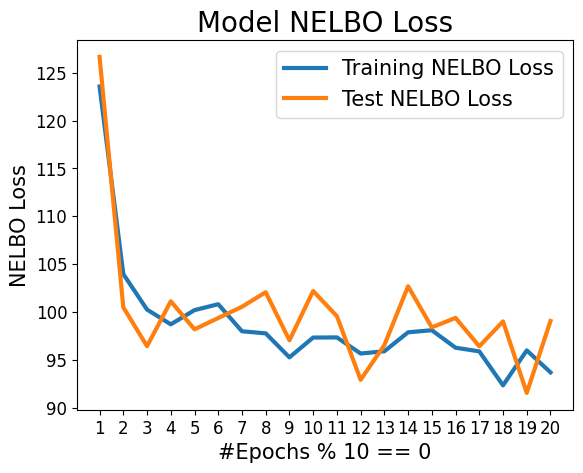

In [7]:
import matplotlib.pyplot as plt

plt.plot(nelbo_train, label="Training NELBO Loss", linewidth=3)
plt.plot(nelbo_test, label="Test NELBO Loss", linewidth=3)
plt.title("Model NELBO Loss", fontsize=20)
plt.xlabel("#Epochs % 10 == 0", fontsize=15)
plt.ylabel("NELBO Loss", fontsize=15)
plt.xticks(range(int(iter_max / 10)), range(1, int(iter_max / 10) + 1), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="best", fontsize=15)
plt.show()

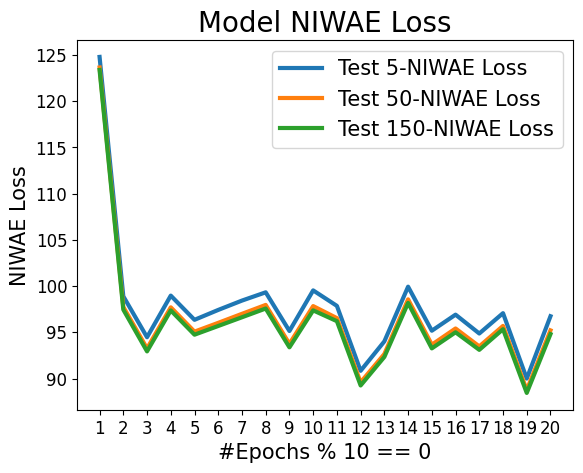

In [8]:
plt.plot(niwae5_test, label="Test 5-NIWAE Loss", linewidth=3)
plt.plot(niwae50_test, label="Test 50-NIWAE Loss", linewidth=3)
plt.plot(niwae150_test, label="Test 150-NIWAE Loss", linewidth=3)
plt.title("Model NIWAE Loss", fontsize=20)
plt.xlabel("#Epochs % 10 == 0", fontsize=15)
plt.ylabel("NIWAE Loss", fontsize=15)
plt.xticks(range(int(iter_max / 10)), range(1, int(iter_max / 10) + 1), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="best", fontsize=15)
plt.show()